In [1]:
import pickle
import re

from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import LsiModel
from gensim.models import LdaModel
from gensim import similarities
import gensim.corpora as corpora
import gensim

# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk

from FuzzyTM import FLSA_W

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# pyLDAvis.enable_notebook()

In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tomdewildt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
with open("../data/documents.pkl", "rb") as input_file:
    tm_data = pickle.load(input_file)   

In [5]:
for i in range(0, 4):
    print(tm_data[i], "\n")

Barclays' defiance of US fines has merit Barclays disgraced itself in many ways during the pre-financial crisis boom years. So it is tempting to think the bank, when asked by US Department of Justice to pay a large bill for polluting the financial system with mortgage junk between 2005 and 2007, should cough up, apologise and learn some humility. That is not the view of the chief executive, Jes Staley. Barclays thinks the DoJâ€™s claims are â€œdisconnected from the factsâ€ and that it has â€œan obligation to our shareholders, customers, clients and employees to defend ourselves against unreasonable allegations and demands.â€ The stance is possibly foolhardy, since going into open legal battle with the most powerful US prosecutor is risky, especially if you end up losing. But actually, some grudging respect for Staley and Barclays is in order. The US system for dishing out fines to errant banks for their mortgage sins has come to resemble a casino. The approach prefers settlements beh

In [6]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # Initialize regex tokenizer
    tokenizer = RegexpTokenizer(r"\w+")

    # Create English stop words list
    en_stop = set(stopwords.words("english"))

    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()

    # List for tokenized documents in loop
    texts = []

    # Loop through document list
    for i in doc_set:
        # Clean and tokenize document string
        raw = i.lower()    
        tokens = tokenizer.tokenize(raw)

        # Remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]

        # Stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

        # Add tokens to list
        texts.append(stemmed_tokens)

    return texts

In [7]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    # Generate LSA model
    return dictionary, doc_term_matrix

In [8]:
def create_gensim_lsa_model(doc_clean, number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)

    # Generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)

    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))

    return lsamodel

In [9]:
def create_gensim_lda_model(doc_clean, number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)

    # Generate LDA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary, passes=10, update_every=1, chunksize=10, alpha="auto")

    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))

    return ldamodel

In [10]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3, tm="lda"):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for topic_num in range(start, stop, step):
        if tm == "lsa":
            model = LsiModel(doc_term_matrix, num_topics=topic_num, id2word=dictionary)
        else:
            model = LdaModel(doc_term_matrix, num_topics=topic_num, id2word=dictionary, passes=10, update_every=1, chunksize=10, alpha="auto")

        model_list.append(model)

        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [11]:
clean_text = preprocess_data(tm_data)

In [12]:
print(clean_text[0])

['barclay', 'defianc', 'us', 'fine', 'merit', 'barclay', 'disgrac', 'mani', 'way', 'pre', 'financi', 'crisi', 'boom', 'year', 'tempt', 'think', 'bank', 'ask', 'us', 'depart', 'justic', 'pay', 'larg', 'bill', 'pollut', 'financi', 'system', 'mortgag', 'junk', '2005', '2007', 'cough', 'apologis', 'learn', 'humil', 'view', 'chief', 'execut', 'je', 'staley', 'barclay', 'think', 'dojâ', 'claim', 'â', 'œdisconnect', 'factsâ', 'â', 'œan', 'oblig', 'sharehold', 'custom', 'client', 'employe', 'defend', 'unreason', 'alleg', 'demand', 'â', 'stanc', 'possibl', 'foolhardi', 'sinc', 'go', 'open', 'legal', 'battl', 'power', 'us', 'prosecutor', 'riski', 'especi', 'end', 'lose', 'actual', 'grudg', 'respect', 'staley', 'barclay', 'order', 'us', 'system', 'dish', 'fine', 'errant', 'bank', 'mortgag', 'sin', 'come', 'resembl', 'casino', 'approach', 'prefer', 'settlement', 'behind', 'close', 'door', 'differ', 'size', 'penalti', 'never', 'explain', 'occasion', 'leak', 'negoti', 'demand', 'make', 'methodolog',

<h2>Results LSA</h2>

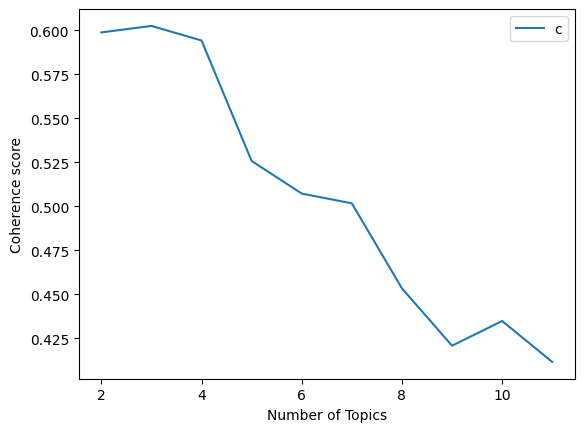

In [13]:
def plot_graph(doc_clean, start, stop, step, t_m="lda"):
    dictionary,doc_term_matrix = prepare_corpus(clean_text)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step, tm=t_m)

    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc="best")
    plt.show()

start, stop, step = 2, 12, 1
plot_graph(clean_text, start, stop, step, t_m="lsa")

In [14]:
# LSA Model
words = 10
new_number_of_topics = 4

model = create_gensim_lsa_model(clean_text, new_number_of_topics, words)
topic_words = model.print_topics(num_topics=new_number_of_topics, num_words=words)

for i, topic in enumerate(topic_words):
    print("Topic ", i, ":", re.findall(r'"(.*?)"', topic[1]))

[(0, '0.869*"â" + 0.155*"trump" + 0.136*"say" + 0.118*"said" + 0.075*"would" + 0.071*"peopl" + 0.070*"clinton" + 0.070*"one" + 0.059*"year" + 0.059*"campaign"'), (1, '-0.389*"citi" + -0.372*"v" + -0.358*"2016" + -0.358*"h" + -0.356*"2017" + -0.165*"unit" + -0.160*"west" + -0.157*"manchest" + -0.116*"apr" + -0.112*"dec"'), (2, '-0.330*"eu" + 0.307*"trump" + -0.244*"say" + 0.222*"â" + -0.215*"would" + -0.173*"leav" + -0.147*"uk" + 0.136*"clinton" + -0.134*"said" + -0.132*"vote"'), (3, '-0.454*"trump" + 0.276*"min" + -0.202*"clinton" + 0.201*"â" + -0.181*"said" + -0.175*"campaign" + -0.172*"eu" + -0.139*"vote" + -0.132*"say" + 0.124*"goal"')]
Topic  0 : ['â', 'trump', 'say', 'said', 'would', 'peopl', 'clinton', 'one', 'year', 'campaign']
Topic  1 : ['citi', 'v', '2016', 'h', '2017', 'unit', 'west', 'manchest', 'apr', 'dec']
Topic  2 : ['eu', 'trump', 'say', 'â', 'would', 'leav', 'uk', 'clinton', 'said', 'vote']
Topic  3 : ['trump', 'min', 'clinton', 'â', 'said', 'campaign', 'eu', 'vote', 

<h2>Results LDA</h2>

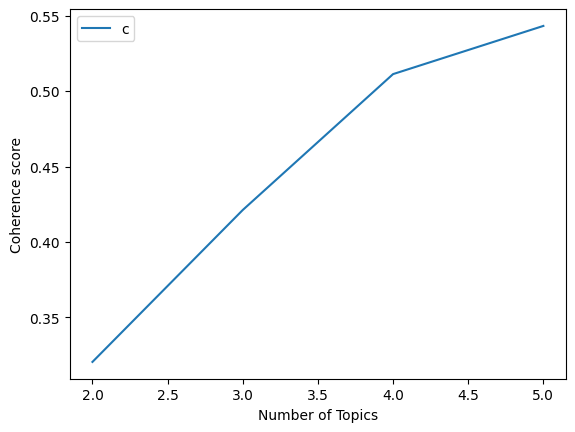

In [15]:
clean_text = preprocess_data(tm_data[:500])

start, stop, step = 2, 6, 1
plot_graph(clean_text, start, stop, step, t_m="lda")

In [16]:
# LDA Model
words = 10
new_number_of_topics = 5

model = create_gensim_lda_model(clean_text, new_number_of_topics,words)
topic_words = model.print_topics(num_topics=new_number_of_topics, num_words=words)

for i, topic in enumerate(topic_words):
    print("Topic ", i, ":", re.findall(r'"(.*?)"', topic[1]))

[(0, '0.073*"â" + 0.008*"one" + 0.008*"like" + 0.008*"itâ" + 0.007*"say" + 0.007*"go" + 0.007*"would" + 0.007*"time" + 0.006*"get" + 0.006*"think"'), (1, '0.045*"trump" + 0.017*"â" + 0.016*"clinton" + 0.015*"said" + 0.014*"campaign" + 0.012*"trumpâ" + 0.012*"elect" + 0.012*"donald" + 0.011*"state" + 0.011*"presid"'), (2, '0.018*"film" + 0.007*"music" + 0.007*"play" + 0.006*"star" + 0.006*"movi" + 0.005*"song" + 0.004*"album" + 0.004*"war" + 0.004*"stori" + 0.004*"charact"'), (3, '0.023*"min" + 0.011*"leagu" + 0.010*"game" + 0.010*"villa" + 0.010*"season" + 0.009*"player" + 0.009*"goal" + 0.008*"team" + 0.008*"everton" + 0.006*"win"'), (4, '0.033*"â" + 0.011*"said" + 0.007*"bank" + 0.006*"year" + 0.006*"would" + 0.005*"eu" + 0.004*"govern" + 0.004*"also" + 0.004*"could" + 0.004*"uk"')]
Topic  0 : ['â', 'one', 'like', 'itâ', 'say', 'go', 'would', 'time', 'get', 'think']
Topic  1 : ['trump', 'â', 'clinton', 'said', 'campaign', 'trumpâ', 'elect', 'donald', 'state', 'presid']
Topic  2 : ['f

<h2>The most dominant topic and its percentage contribution in each document</h2>

In [17]:
def format_topics_sentences(ldamodel, cleaned_text):
    """
    Input   : ldamodel : Gensim generated LDA model
            cleaned_text : preprocessed text
    purpose : Find the most dominant topic in each document and its percentage contribution
    Output  : Dataframe displaying the  most dominant topic in each document and its percentage contribution
    """
    dictionary, docterm_matrix = prepare_corpus(cleaned_text)
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[docterm_matrix]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break

    sent_topics_df.columns = ["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]

    # Add original text to the end of the output
    contents = pd.Series(cleaned_text)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    return(sent_topics_df)

In [18]:
df_topic_sents_keywords = format_topics_sentences(model, clean_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ["Document_No", "Dominant_Topic", "Topic_Perc_Contrib", "Keywords", "Text"]
df_dominant_topic.head(10)

/tmp/ipykernel_478002/2541561439.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.7117,"â, said, bank, year, would, eu, govern, also, ...","[barclay, defianc, us, fine, merit, barclay, d..."
1,1,4,0.3782,"â, said, bank, year, would, eu, govern, also, ...","[big, hillari, clinton, lead, presidenti, race..."
2,2,4,0.4375,"â, said, bank, year, would, eu, govern, also, ...","[zikaâ, greatest, alli, human, intransig, reve..."
3,3,1,0.4074,"trump, â, clinton, said, campaign, trumpâ, ele...","[fight, right, cruz, rubio, spar, nevada, trum..."
4,4,4,0.3497,"â, said, bank, year, would, eu, govern, also, ...","[vote, day, america, final, goe, poll, candid,..."
5,5,4,0.4975,"â, said, bank, year, would, eu, govern, also, ...","[twitter, u, turn, ban, white, nationalist, tw..."
6,6,0,0.4949,"â, one, like, itâ, say, go, would, time, get, ...","[ariana, grand, donut, lick, cost, gig, white,..."
7,7,0,0.5172,"â, one, like, itâ, say, go, would, time, get, ...","[never, mind, john, lewi, â, tv, advert, music..."
8,8,4,0.6632,"â, said, bank, year, would, eu, govern, also, ...","[innov, fund, aim, save, women, newborn, babi,..."
9,9,4,0.8764,"â, said, bank, year, would, eu, govern, also, ...","[polic, search, santand, madrid, hq, money, la..."


<h2>The most representative sentence for each topic</h2>

In [19]:
pd.options.display.max_colwidth = 100

def most_repr_sent_tp(document_dom_topic_df):
    """
    Input   : ldamodel : Dataframe containing the most dominant topic and its contribution per document
    purpose : Find the most representative sentence for each topic
    Output  : Dataframe displaying the most representative sentence for each topic
    """
    sent_topics_sorted_df = pd.DataFrame()

    grouped_document_dom_topic_df = document_dom_topic_df.groupby("Dominant_Topic")

    for i, grp in grouped_document_dom_topic_df:
        sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, grp.sort_values(["Perc_Contribution"], ascending=False).head(1)], axis=0)

    sent_topics_sorted_df.reset_index(drop=True, inplace=True)

    sent_topics_sorted_df.columns = ["Topic_Num", "Topic_Perc_Contrib", "Keywords", "Representative Text"]

    return sent_topics_sorted_df

In [20]:
most_repr_sent_tp(df_topic_sents_keywords)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.7964,"â, one, like, itâ, say, go, would, time, get, think","[itâ, twitterâ, 10th, birthday, love, hate, abi, wilkinson, â, twitter, allow, us, break, seem, ..."
1,1,0.5173,"trump, â, clinton, said, campaign, trumpâ, elect, donald, state, presid","[democrat, seek, injunct, trump, alli, voter, intimid, concern, democrat, parti, offici, four, s..."
2,2,0.6580,"film, music, play, star, movi, song, album, war, stori, charact","[ryan, gosl, emma, stone, music, la, la, land, open, venic, film, festiv, whiplash, director, da..."
3,3,0.7197,"min, leagu, game, villa, season, player, goal, team, everton, win","[manchest, unit, v, tottenham, hotspur, match, preview, mood, manchest, unit, one, frustrat, mix..."
4,4,0.9768,"â, said, bank, year, would, eu, govern, also, could, uk","[uk, asset, resolut, deal, trigger, bonus, 2, 000, employe, deal, outsourc, mortgag, process, go..."


<h2>Visualize topics using pyLDAvis</h2>

In [21]:
# def viz_topics(cleaned_text, topics, words=1000):
#     dictionary, docterm_matrix = prepare_corpus(cleaned_text)

#     model = create_gensim_lda_model(cleaned_text, topics, 10)

#     vis = gensimvis.prepare(model, docterm_matrix, dictionary)

#     return vis

In [22]:
# vizualization = viz_topics(clean_text, 4)

In [23]:
# pyLDAvis.display(vizualization)

## FuzzyTM

In [24]:
# Initialize model
flsaW = FLSA_W(
    input_file=clean_text,
    num_topics=10,
    num_words=10,
    word_weighting="normal",
    cluster_method="fcm",
)

# Train topic model and obtain to matrices
pwgt, ptgd = flsaW.get_matrices()

# Get topics
topics = flsaW.show_topics(representation="words")

print(topics)

[['never', 'servic', 'power', 'director', 'financi', 'secur', 'system', 'repres', 'risk', 'complet'], ['guardian', 'swift', 'supermarket', '7m', 'lineup', 'olymp', 'menâ', 'specialis', 'guitarist', 'neglect'], ['effect', '50', 'limit', 'focu', 'manag', 'drive', '17', 'scale', '8', '2010'], ['organis', 'treat', 'eye', 'troubl', 'imag', 'twitter', 'opinion', 'fulli', 'none', 'daughter'], ['alreadi', 'appear', 'well', 'recent', 'run', 'think', 'like', 'thing', 'larg', 'sever'], ['artist', '2011', 'attitud', 'comedi', 'band', 'technolog', 'collabor', 'album', 'pop', 'fashion'], ['cut', 'govern', 'increas', 'deliv', 'invest', 'chang', 'econom', 'credit', 'rise', 'spend'], ['profession', 'qualiti', 'previou', 'player', 'quickli', 'star', 'heart', 'equal', 'maintain', 'imagin'], ['michael', 'pleas', 'newspap', 'stronger', 'nicola', 'round', 'fascin', 'split', 'polic', 'pro'], ['count', 'nigel', 'bet', 'poll', 'vote', 'remain', 'rain', 'flood', 'briton', 'farag']]


In [25]:
for id, tp in enumerate(topics):
    print("Topic " , id, ":", tp)

Topic  0 : ['never', 'servic', 'power', 'director', 'financi', 'secur', 'system', 'repres', 'risk', 'complet']
Topic  1 : ['guardian', 'swift', 'supermarket', '7m', 'lineup', 'olymp', 'menâ', 'specialis', 'guitarist', 'neglect']
Topic  2 : ['effect', '50', 'limit', 'focu', 'manag', 'drive', '17', 'scale', '8', '2010']
Topic  3 : ['organis', 'treat', 'eye', 'troubl', 'imag', 'twitter', 'opinion', 'fulli', 'none', 'daughter']
Topic  4 : ['alreadi', 'appear', 'well', 'recent', 'run', 'think', 'like', 'thing', 'larg', 'sever']
Topic  5 : ['artist', '2011', 'attitud', 'comedi', 'band', 'technolog', 'collabor', 'album', 'pop', 'fashion']
Topic  6 : ['cut', 'govern', 'increas', 'deliv', 'invest', 'chang', 'econom', 'credit', 'rise', 'spend']
Topic  7 : ['profession', 'qualiti', 'previou', 'player', 'quickli', 'star', 'heart', 'equal', 'maintain', 'imagin']
Topic  8 : ['michael', 'pleas', 'newspap', 'stronger', 'nicola', 'round', 'fascin', 'split', 'polic', 'pro']
Topic  9 : ['count', 'nigel',

## Evaluation

In [26]:
# Evaluation
coherence = flsaW.get_coherence_score(input_file=clean_text, topics=topics)
diversity = flsaW.get_diversity_score(topics=topics)
interpretability = flsaW.get_interpretability_score(input_file=clean_text, topics=topics)

print(topics)

print("Coherence score: ", str(coherence), "Diversity score:", str(diversity), "Interpretability score: ", str(interpretability), sep="\n")

[['never', 'servic', 'power', 'director', 'financi', 'secur', 'system', 'repres', 'risk', 'complet'], ['guardian', 'swift', 'supermarket', '7m', 'lineup', 'olymp', 'menâ', 'specialis', 'guitarist', 'neglect'], ['effect', '50', 'limit', 'focu', 'manag', 'drive', '17', 'scale', '8', '2010'], ['organis', 'treat', 'eye', 'troubl', 'imag', 'twitter', 'opinion', 'fulli', 'none', 'daughter'], ['alreadi', 'appear', 'well', 'recent', 'run', 'think', 'like', 'thing', 'larg', 'sever'], ['artist', '2011', 'attitud', 'comedi', 'band', 'technolog', 'collabor', 'album', 'pop', 'fashion'], ['cut', 'govern', 'increas', 'deliv', 'invest', 'chang', 'econom', 'credit', 'rise', 'spend'], ['profession', 'qualiti', 'previou', 'player', 'quickli', 'star', 'heart', 'equal', 'maintain', 'imagin'], ['michael', 'pleas', 'newspap', 'stronger', 'nicola', 'round', 'fascin', 'split', 'polic', 'pro'], ['count', 'nigel', 'bet', 'poll', 'vote', 'remain', 'rain', 'flood', 'briton', 'farag']]
Coherence score: 
0.406594018